<a href="https://colab.research.google.com/github/sumadvena/SiOC_2023/blob/main/SiOC_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#INTERPOLACJA 1D

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import interpolate
from sklearn import metrics

from typing import NamedTuple, Sequence

In [2]:
sns.set()

In [3]:
N_MEASUREMENTS = 40

In [4]:
def simple(x):
    return np.sin(x)

def inverted_sin(x):
    return np.sin(np.power(x, -1))

def sign(x):
    return np.sign(np.sin(8*x))

In [5]:
x = np.linspace(-np.pi, np.pi, N_MEASUREMENTS)

y_simple = simple(x)
y_sin_func = inverted_sin(x)
y_sgn_func = sign(x)


In [6]:
def nearest_neighbour_kernel(x, offset: float, width: float):
    """Nearest neighbour interpolation kernel"""
    x = x - offset
    return (x >= (-1 * width / 2)) * (x < width / 2)


def linear_kernel(x, offset: float, width: float):
    """Linear interpolation kernel"""
    x = x - offset
    x = x / width
    return (1 - np.abs(x)) * (np.abs(x) < 1)


def sinc_kernel(x, offset: float, width: float, alpha: float = np.pi):
    """Normalized sine interpolation kernel"""
    x = x - offset
    x = x / width
    return (x >= -alpha) * (x < alpha) * np.sinc(x)

In [7]:
class PlotData(NamedTuple):
    """Simple container for plot data"""

    x: Sequence[float]
    y: Sequence[float]


def plot_interpolation(measure: PlotData, interpolation: PlotData, real: PlotData, figsize=(12, 8)):
    """Plot the interpolation, measurements and the real function"""
    figure = plt.figure(figsize=figsize)  # noqa

    plt.scatter(measure.x, measure.y, label="Measurements")
    plt.plot(interpolation.x, interpolation.y, label="Interpolation")
    plt.plot(real.x, real.y, label="Real Function")

    plt.legend()

In [8]:
def conv1d_interpolate(x_measure: np.array, y_measure: np.array, x_interpolate: np.array, kernel: callable) -> np.array:
    """
    Interpolate using a convolution kernel

    :param x_measure: x values of the measurements
    :param y_measure: y values of the measurements
    :param x_interpolate: x values of the interpolation
    :param kernel: callable interpolation kernel accepting x, offset and width

    :return: y values of the interpolation
    """
    width = x_measure[1] - x_measure[0]  # store period between samples
    kernels = [kernel(x_interpolate, offset=offset, width=width) for offset in x_measure]

    return y_measure @ kernels

MSE: 0.03625854


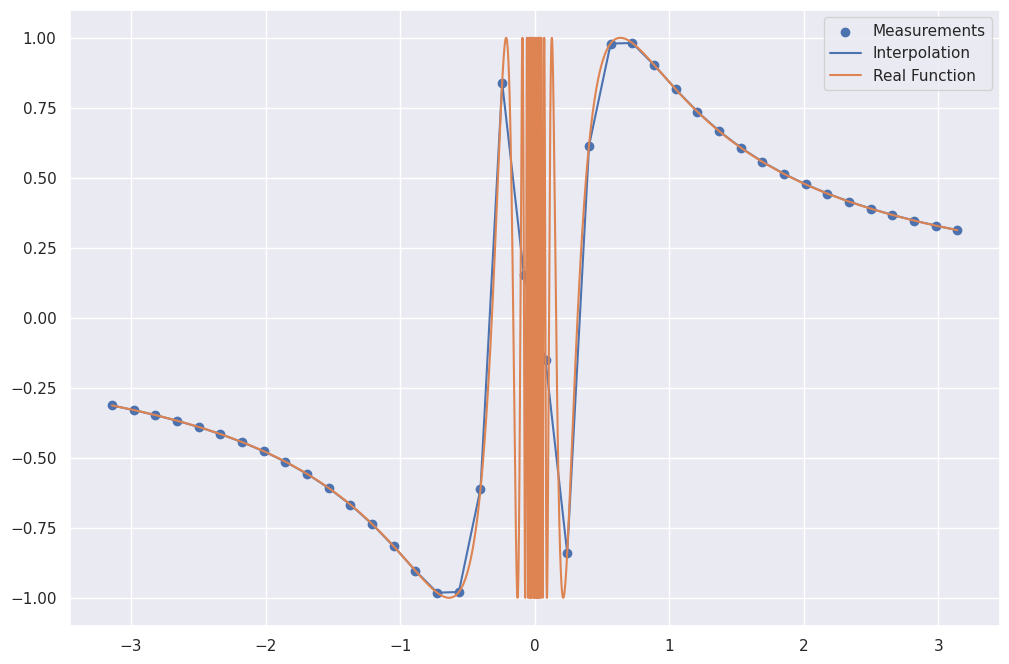

In [9]:
n_predictions = 100000

x_interp = np.linspace(-np.pi, np.pi, n_predictions)
y = inverted_sin(x)

y_interp = conv1d_interpolate(x_measure=x, y_measure=y, x_interpolate=x_interp, kernel=linear_kernel)
y_true = inverted_sin(x_interp)


print(f"MSE: {metrics.mean_squared_error(y_pred=y_interp, y_true=y_true):.8f}")
plot_interpolation(measure=PlotData(x=x, y=y), interpolation=PlotData(x=x_interp, y=y_interp), real=PlotData(x=x_interp, y=y_true))

#INTERPOLACJA 2D

In [10]:
from numpy.typing import NDArray
from skimage import io, transform, color
import fractions
from skimage.util import view_as_windows

###Downsampling

In [11]:
def downsample(image: NDArray, kernel_size: int = 2) -> np.array:
    """Downsample an image using a convolution kernel"""
    kernel = np.ones((kernel_size, kernel_size)) / kernel_size**2
    windows = view_as_windows(image, window_shape=kernel_size, step=kernel_size)
    return np.apply_over_axes(np.sum, windows * kernel, axes=(2, 3)).squeeze()


def rgb_downsample(image: NDArray, kernel_size: int = 2, downsample_func: callable = downsample) -> NDArray:
    """Downsample an RGB image by applying the downsample function to each channel"""
    return np.stack([downsample_func(image[:, :, channel], kernel_size) for channel in range(3)], axis=2)

In [12]:
color_image = io.imread(r"/content/wp9554772-pieta-wallpapers.jpg")
color_image = transform.resize(color_image, output_shape=(1000, 1000, 3))

grey_image = color.rgb2gray(color_image)
grey_image.shape, color_image.shape

((1000, 1000), (1000, 1000, 3))

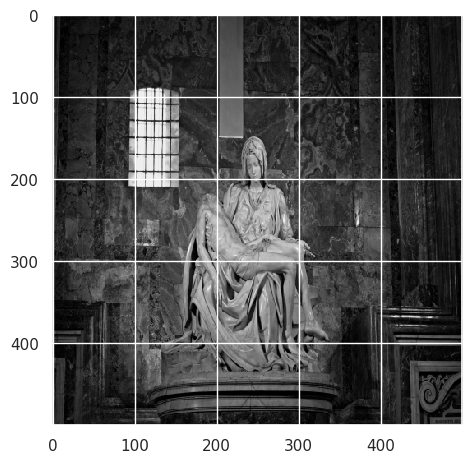

In [13]:
rgb_downsampled = rgb_downsample(color_image, kernel_size=2)
gray_downsampled = downsample(grey_image, kernel_size=2)
_ = io.imshow(gray_downsampled)

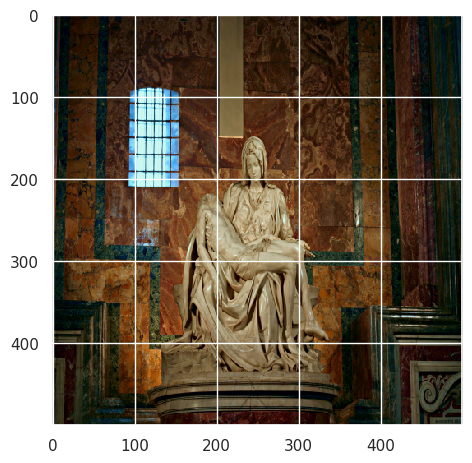

In [16]:
_ = io.imshow(rgb_downsampled)

###Upsampling

In [14]:
def image_interpolate(image: NDArray, kernel: callable, ratio: int) -> NDArray:
    """Interpolate an image using a convolution kernel"""

    def row_column_interpolate(row: NDArray) -> NDArray:
        """Interpolate a single row or column of the image"""
        x_measure = np.arange(len(row))
        x_interpolate = np.linspace(0, len(row), ratio * len(row), endpoint=False)
        return conv1d_interpolate(x_measure, row, x_interpolate, kernel)

    interpolated = np.apply_along_axis(row_column_interpolate, 1, image)
    return np.apply_along_axis(row_column_interpolate, 0, interpolated)


def rgb_image_interpolate(image: NDArray, kernel: callable, ratio: int) -> NDArray:
    """Interpolate an RGB image by applying the image interpolation function to each channel"""
    return np.stack([image_interpolate(image[:, :, channel], kernel, ratio) for channel in range(3)], axis=2)

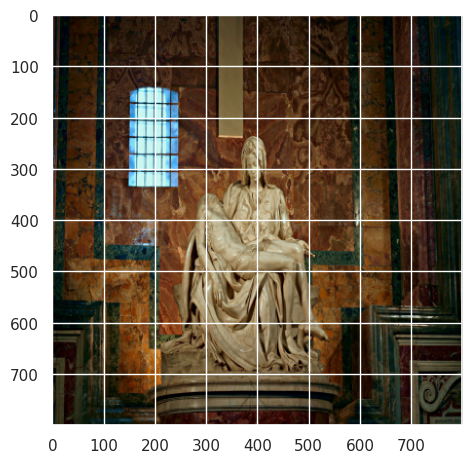

In [17]:
upsampled = image_interpolate(grey_image, kernel=linear_kernel, ratio=2)

color_image = transform.resize(color_image, output_shape=(400, 400, 3))  # scale down to avoid long wait time
color_upsampled_image = rgb_image_interpolate(color_image, kernel=linear_kernel, ratio=2)

_ = io.imshow(color_upsampled_image)

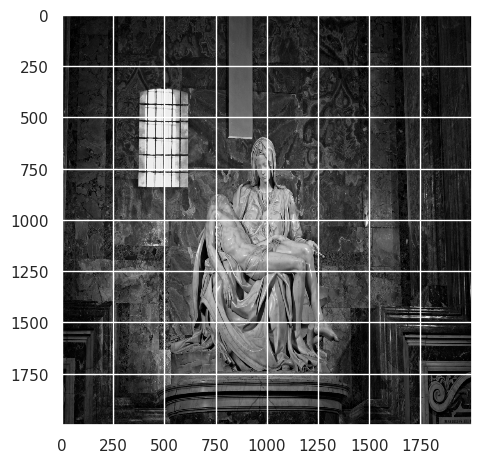

In [18]:
_ = io.imshow(upsampled)